**This notebook is closer to the original version of this assessment. I decided that implementing a full covariance approximate posterior (as in the original version) would be too hard (using TFP the student could just use `MultivariateNormalTriL`), so use a diagonal Gaussian instead. I kept everything else the same, including the mixture of Gaussians prior. However, the training was unstable and kept going straight to NaN - I'm guessing this was due to the change of posterior. I changed the prior to a $N(\mathbf{0}, \mathbf{I})$ and this helped to stabilise the training. However, the final KL loss is high, so that sampling from the model gives garbage. So I removed the sampling section.**

# Deep Learning
## Formative assessment
### Week 10: Variational autoencoder

#### Instructions

In this notebook, you will write code to implement the variational autoencoder algorithm for an image dataset of celebrity faces. You will use the trained encoder and decoder networks to reconstruct and generate images. You will also see how the latent space encodes high-level information about the images.

Some code cells are provided you in the notebook. You should avoid editing provided code, and make sure to execute the cells in order to avoid unexpected errors. Some cells begin with the line: 

`#### GRADED CELL ####`

These cells require you to write your own code to complete them.

#### Let's get started!

We'll start by running some imports, and loading the dataset.

In [1]:
import os
os.environ['KERAS_BACKEND'] = 'torch'
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

In [23]:
#### PACKAGE IMPORTS ####

# Run this cell first to import all required packages. Do not make any imports elsewhere in the notebook

import keras
from keras import ops
import tensorflow as tf
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

from keras import Sequential, Model
from keras.layers import Layer, Input, Dense, Flatten, Reshape, Conv2D,  Conv2DTranspose, BatchNormalization
from keras.metrics import Mean

<center><img src="figures/celeba.png" title="CelebA" style="width: 650px;"/></center>

#### The Large-scale CelebFaces Attributes (CelebA) Dataset

For this assignment you will use a subset of the [CelebFaces Attributes (CelebA) dataset](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). The full dataset contains over 200K images CelebA contains thousands of colour images of the faces of celebrities, together with tagged attributes such as 'Smiling', 'Wearing glasses', or 'Wearing lipstick'. It also contains information about bounding boxes and facial part localisation. CelebA is a popular dataset that is commonly used for face attribute recognition, face detection, landmark (or facial part) localization, and face editing & synthesis. 

* Z. Liu, P. Luo, X. Wang, and X. Tang. "Deep Learning Face Attributes in the Wild", Proceedings of International Conference on Computer Vision (ICCV), 2015.

Your goal is to implement the variational autoencoder algorithm for a subset of the CelebA dataset. For practical reasons we will keep the dataset and the network size relatively small.

#### Load and preprocess the dataset

For this assignment, you will use a subset of the CelebA dataset. Note that the full dataset can be downloaded from [the CelebA dataset webpage](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)), but this is not necessary for this assignment. 

In addition, attribute labels for the subset have been saved in the CSV file `list_attr_celeba.csv`. We will use this in the last part of the assignment.

You should now write the following `load_dataset` function to create a `tf.data.Dataset` object from the files saved in the images folder.

* The function takes `split` as an argument, which will be equal to one of the strings `"train"`, `"val"` or  `"test"`, `batch_size`, an optional `shuffle_buffer` argument and `image_dir` argument
* The function should create a Dataset containing the filepaths saved in the corresponding `split` subfolder of the `image_dir` directory
* The function should include a nested/inner function used to map the Dataset
  * This function will take the `filepath` as an argument
  * It should read the contents of the file saved at `filepath` - this will be a jpeg image
  * It should then decode the jpeg and scale the pixel values to lie in the range $[0, 1]$
  * It should then the image Tensor
* The function should then apply the nested function using the `map` method
* If `shuffle_buffer` is not None, then it should be used to shuffle the Dataset
* It should then batch the Dataset using the `batch_size` argument
* Finally, the function should prefetch the Dataset using the argument `tf.data.AUTOTUNE`
* The function should then return the Dataset

_Hint: The Dataset can be created using_ `tf.data.Dataset.list_files`, _and using a wildcard character_ `'*.jpg'`_. Make sure that you set_ `shuffle=False` _when calling this method._

In [3]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def load_dataset(split, batch_size, shuffle_buffer=None, image_dir=str(Path('data', 'images'))):
    """
    This function should create a tf.data.Dataset object for one of the train/valid/test
    splits, according to the above specification.
    It should then return the Dataset.
    """
    dataset = tf.data.Dataset.list_files(str(Path(image_dir, split, '*.jpg')), shuffle=False)
    
    def load_image(filepath):
        raw_img = tf.io.read_file(filepath) 
        img_tensor = tf.image.decode_jpeg(raw_img, channels=3)
        img_tensor = tf.image.convert_image_dtype(img_tensor, tf.float32)
        return img_tensor
    
    dataset = dataset.map(load_image)
    if shuffle_buffer is not None:
        dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [4]:
# Use your function to obtain the train, valid and test Datasets

train_ds = load_dataset('train', 32, shuffle_buffer=500)
valid_ds = load_dataset('val', 32)
test_ds = load_dataset('test', 8)

2024-08-26 14:48:48.298818: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


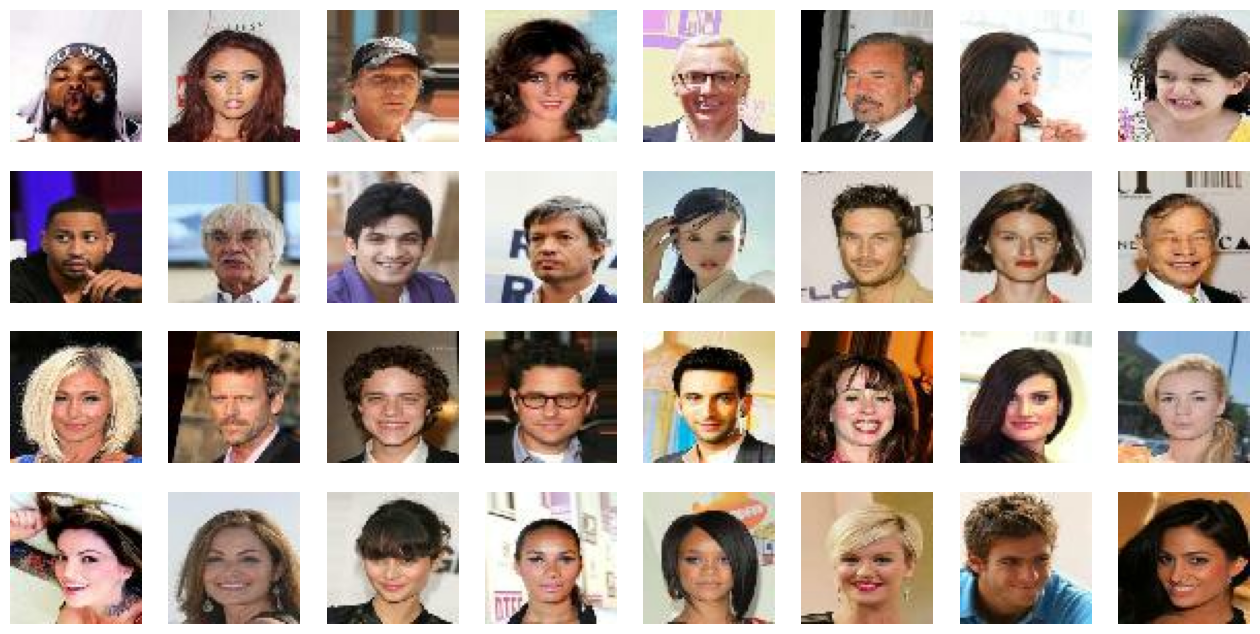

In [5]:
# Display a few examples

n_rows, n_cols = 4, 8
f, axs = plt.subplots(n_rows, n_cols, figsize=(16, 8))

for img_batch in train_ds.take(1):
    img_batch = ops.convert_to_numpy(img_batch)
    for n, image in enumerate(img_batch):
        i = n // n_cols
        j = n % n_cols
        axs[i, j].imshow(image)
        axs[i, j].axis('off')

#### Define the prior distribution

We will use a prior distribution that is a mixture of Gaussians. We will implement sampling from the prior as a custom layer. We will need this layer to evaluate the log-pdf of the prior distribution, as well as to sample from the prior. 

You should now complete the following `Prior` class to define the mixture of Gaussians distribution for the prior, for a given number of components and latent space dimension. Each Gaussian component will have a diagonal covariance matrix. This distribution will have fixed mixing coefficients, but trainable means and standard deviations. 

* The class takes `num_modes` (number of components) and `latent_dim` as arguments
* The initializer should define trainable variables for the prior means and log standard deviations.
  * Both of these variables should have shape `(num_modes, latent_dim)`
  * The means variable should be initialized using zero mean, isotropic Gaussian distributions with standard deviation equal to 0.01
  * The log standard deviations variable should be initialized to zeros
* The categorical distribution for the mixture components should be uniform
* The `call` method takes an `inputs` Tensor of `(batch_size, latent_dim)` and evaluates the log probability density function of the mixture of Gaussians prior. It should return a Tensor of shape `(batch_size,)`
* The `sample` method takes a `batch_size` argument and returns a sample from the mixture of Gaussians prior distribution of shape `(batch_size, latent_dim)`. The layer should sample a mixture component, and then sample from the corresponding Gaussian distribution using the corresponding mean and log standard deviation from the layer variables.

_Hint: you may find the [`keras.random.categorical`](https://keras.io/api/random/random_ops/#categorical-function), [`keras.random.normal`](https://keras.io/api/random/random_ops/#normal-function) and [`ops.take_along_axis`](https://keras.io/api/ops/numpy/#take_along_axis-function) functions useful._

In [6]:
#### GRADED CELL ####

# Complete the following class. 
# Make sure to not change the function name or arguments.

class Prior(Layer):
    
    def __init__(self, num_modes, latent_dim, **kwargs):
        """
        Class initializer takes num_modes num_filters and latent_dim as arguments, and 
        optional keyword arguments that should be passed to the base Layer class initializer.
        As the layer does not depend on the inputs, the trainable variables can be created here.
        """
        super().__init__(**kwargs)
        self.num_modes = num_modes
        self.latent_dim = latent_dim
        self.mean = self.add_weight(shape=(num_modes, latent_dim),
                                    initializer=keras.initializers.RandomNormal(stddev=0.01),
                                    trainable=True,
                                    name='prior_mean')
        self.logstd = self.add_weight(shape=(num_modes, latent_dim),
                                      initializer='zeros',
                                      trainable=True,
                                      name='prior_log_std')
        self.pi = ops.array(np.pi)

    def call(self, inputs):
        """
        The call takes an input Tensor of shape (batch_size, latent_dim) and computes the 
        log probability density function of the mixture of Gaussians prior distribution.
        It returns a Tensor of shape (batch_size,).
        """
        assert ops.shape(inputs)[-1] == self.latent_dim, f"inputs should have shape (:, {self.latent_dim}), received {inputs.shape}"
        inputs = ops.expand_dims(inputs, axis=-2)  # (B, 1, L)
        log_Z = 0.5 * ops.log(2 * self.pi)
        logpdf = -0.5 * ops.square((inputs - self.mean) / ops.exp(self.logstd)) - self.logstd - log_Z  # (B, M, L)
        return ops.log(ops.mean(ops.exp(ops.sum(logpdf, axis=-1)), axis=-1))

    def sample(self, batch_size):
        """
        The sample method takes a batch_size argument and returns a sample
        from the prior distribution of shape (batch_size, latent_dim).
        """
        mode = keras.random.categorical(ops.zeros((batch_size, self.num_modes)), 1)
        mode = ops.expand_dims(mode, -1)  # (B, 1, 1)
        
        mean = ops.take_along_axis(ops.expand_dims(self.mean, 0), mode, axis=-2)  # (B, 1, L)
        mean = ops.squeeze(mean, axis=-2)  # (B, L)

        logstd = ops.take_along_axis(ops.expand_dims(self.logstd, 0), mode, axis=-2)  # (B, 1, L)
        logstd = ops.squeeze(logstd, axis=-2)  # (B, L)

        epsilon = keras.random.normal((batch_size, self.latent_dim))    
        return mean + (epsilon * ops.exp(logstd))

In [29]:
# Define the prior distribution with 2 components and 50 dimensions for the latent space

prior = Prior(num_modes=2, latent_dim=50)

#### Define the encoder network

We will now define the encoder network as part of the VAE. The approximate posterior $q_\phi(z\mid x)$ defined by the encoder will be a diagonal Gaussian distribution. You should complete the following function to define the encoder network, according to the following specification:

* The function takes the `latent_dim` as an argument
* Use the functional API to define the model, which has the following layers:
  * An Input layer that sets the input shape to `(64, 64, 3)`
  * A Conv2D layer with 32 filters, 3x3 kernel size, ReLU activation, stride of 2x2, and 'SAME' padding
  * BatchNormalization layer
  * Conv2D layer with 64 filters, 3x3 kernel size, ReLU activation, stride of 2x2, and 'SAME' padding
  * BatchNormalization layer
  * Conv2D layer with 128 filters, 3x3 kernel size, ReLU activation, stride of 2x2, and 'SAME' padding
  * BatchNormalization layer
  * Conv2D layer with 256 filters, 3x3 kernel size, ReLU activation, stride of 2x2, and 'SAME' padding
  * BatchNormalization layer
  * Flatten layer
  * Dense layer with no activation function, and the right number of units to parameterise the means and log variance of a diagonal Gaussian distribution of dimension `latent_dim`
  * The resulting Tensor should be split into `z_mean` and `z_log_var` Tensors
  * The encoder Model should output the mean and log variance Tensors in a list `[z_mean, z_log_var]`
* The function should then return the encoder model

In [30]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def get_encoder(latent_dim):
    """
    This function should build a CNN encoder model according to the above specification. 
    The function takes latent_dim as an argument, which should be used to define the model.
    Your function should return the encoder model.
    """
    encoder_inputs = Input(shape=(64, 64, 3))
    h = Conv2D(32, 3, activation='relu', strides=2, padding='same')(encoder_inputs)  # (32, 32, 32)
    h = BatchNormalization()(h)
    h = Conv2D(64, 3, activation='relu', strides=2, padding='same')(h)  # (16, 16, 64)
    h = BatchNormalization()(h)
    h = Conv2D(128, 3, activation='relu', strides=2, padding='same')(h)  # (8, 8, 128)
    h = BatchNormalization()(h)
    h = Conv2D(256, 3, activation='relu', strides=2, padding='same')(h)  # (4, 4, 256)
    h = BatchNormalization()(h)
    h = Flatten()(h)
    h = Dense(2 * latent_dim)(h)
    z_mean, z_log_var = ops.split(h, 2, axis=-1)
    return Model(inputs=encoder_inputs, outputs=[z_mean, z_log_var], name='encoder')  

In [31]:
# Run your function to get the encoder

encoder = get_encoder(latent_dim=50)

In [32]:
# Print the encoder summary

encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │       409,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ split_1 (Split)                 │ [(None, 50), (None,    │             0 │
│                                 │ 50)]                   │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 800,036 (3.05 MB)

 Trainable params: 799,076 (3.05 MB)

 Non-trainable params: 960 (3.75 KB)

#### Define the decoder network

You should now define the decoder network for the VAE, using the functional API. This should be a neural network that returns a logits Tensor of shape `(64, 64, 3)` that will be used to parameterise independent Bernoulli distributions per pixel and colour channel.

* The function takes the `latent_dim` as an argument
* Use the functional API to define the model with the following layers:
  * An Input layer that sets the input shape to `(latent_dim,)`
  * A Dense layer with 4096 units and ReLU activation
  * A Reshape layer, that reshapes its input to `(4, 4, 256)`
  * BatchNormalization layer
  * Conv2DTranspose layer with 128 filters, 3x3 kernel size, ReLU activation, stride of 2x2 and 'SAME' padding
  * BatchNormalization layer
  * Conv2DTranspose layer with 64 filters, 3x3 kernel size, ReLU activation, stride of 2x2 and 'SAME' padding
  * BatchNormalization layer
  * Conv2DTranspose layer with 32 filters, 3x3 kernel size, ReLU activation, stride of 2x2 and 'SAME' padding
  * BatchNormalization layer
  * Conv2DTranspose layer with 3 filters, 3x3 kernel size, no activation function, stride of 2x2 and 'SAME' padding
* The Conv2DTranspose layers will need to be configured such that the final Conv2DTranspose layer outputs a Tensor of shape `(64, 64, 3)` in the final layer. You should pass in the `output_padding` argument to each of these layers.
* The function should then return the decoder model

In [33]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def get_decoder(latent_dim):
    """
    This function should build a CNN decoder model according to the above specification. 
    The function takes latent_dim as an argument, which should be used to define the model.
    Your function should return the decoder model.
    """
    event_shape = (64, 64, 3)
    
    decoder_inputs = Input(shape=(latent_dim,))
    h = Dense(4096, activation='relu')(decoder_inputs)
    h = Reshape((4, 4, 256))(h)
    h = BatchNormalization()(h)
    h = Conv2DTranspose(128, 3, activation='relu', strides=2, padding='same', output_padding=1)(h)
    h = BatchNormalization()(h)
    h = Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same', output_padding=1)(h)
    h = BatchNormalization()(h)
    h = Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same', output_padding=1)(h)
    h = BatchNormalization()(h)
    decoder_outputs = Conv2DTranspose(3, 3, strides=2, padding='same', output_padding=1)(h)

    return Model(inputs=decoder_inputs, outputs=decoder_outputs, name='decoder')

In [34]:
# Run your function to get the decoder

decoder = get_decoder(latent_dim=50)

In [35]:
# Print the decoder summary

decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4096)           │       208,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 8, 8, 128)      │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 64, 64, 3)      │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 598,979 (2.28 MB)

 Trainable params: 598,019 (2.28 MB)

 Non-trainable params: 960 (3.75 KB)

#### Build the end-to-end architecture

Now that the encoder and decoder networks are defined, you should now complete the following `CelebAVAE` class to build the complete encoder-decoder architecture. 

* The `CelebAVAE` class subclasses from the base `Model` class
* The function takes the `encoder` and `decoder` networks, and the `prior` sampling function as arguments
* You should complete the `_get_losses` method
* The `_get_losses` method should compute and return the loss, KL divergence loss and negative log-likelihood loss as a tuple `(loss, kl_loss, nll_loss)`
  * You should use the following form of the SGVB estimator with $L=3$:
$$
\hat{\mathcal{L}}^A(\theta,\phi;x) := \frac{1}{L} \sum_{j=1}^L \log p_\theta(x \mid z^{(j)}) + \log p_\theta(z^{(j)}) − \log q_\phi(z^{(j)}|x)
$$
where $z^{(j)} = g_\phi(\epsilon^{(j)}, x)$, $\epsilon^{(j)}\sim p(\epsilon)$ and $p(\epsilon) = N(\mathbf{0}, \mathbf{I})$. Note that due to our choice of the prior distribution, the KL divergence term cannot be computed analytically.
* The `train_step` method is completed for you. It computes the losses, perform the gradient update and update the metrics
* The `test_step` method is completed for you. It computes the losses and update the metrics
* The `call` method is completed for you. It passes a batch of inputs through the end-to-end encoder-decoder architecture. It uses a single Monte Carlo sample to evaluate the likelihood

In [45]:
 #### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

class CelebAVAE(Model):
    
    def __init__(self, encoder, decoder, prior, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.prior = prior
        self.loss_metric = Mean(name='loss')
        self.nll_metric = Mean(name='nll')
        self.kl_metric = Mean(name='kl')
        self.pi = ops.array(np.pi)
    
    def _get_losses(self, data):
        """
        This method should compute and return the loss, kl_loss and nll_loss.
        It should use 3 Monte Carlo samples and the first form of the SGVB estimator.
        """
        z_mean, z_log_var = self.encoder(data)
        batch_size, latent_dim = ops.shape(z_mean)[0], ops.shape(z_mean)[1]
        epsilon = keras.random.normal((3, batch_size, latent_dim))
        z_std = ops.exp(0.5 * z_log_var)
        posterior_samples = z_mean + (z_std * epsilon)  # (3, B, L)

        prior_log_prob = ops.mean(self.prior(ops.reshape(posterior_samples, (3*batch_size, latent_dim))))
        # The following is for standard Gaussian
        # log_Z = 0.5 * ops.log(2 * self.pi)
        # prior_log_prob = -0.5 * ops.square(posterior_samples) - log_Z
        # prior_log_prob = ops.mean(ops.sum(prior_log_prob, axis=-1))
        
        log_Z = 0.5 * ops.log(2 * self.pi)
        posterior_log_prob = -0.5 * ops.square((posterior_samples - z_mean) / z_std) - ops.log(z_std) - log_Z
        posterior_log_prob = ops.mean(ops.sum(posterior_log_prob, axis=-1))
        
        kl_loss = posterior_log_prob - prior_log_prob
        
        posterior_samples = ops.reshape(posterior_samples, (3 * batch_size, latent_dim))
        
        x_logits = self.decoder(posterior_samples)  # (3*B, 64, 64, 3)
        x_logits = ops.reshape(x_logits, (3, batch_size, 64, 64, 3, 1))
        data = ops.reshape(data, (1, batch_size, 64, 64, 3, 1))
        data = ops.repeat(data, 3, axis=0)
        nll_loss = keras.losses.binary_crossentropy(data, x_logits, from_logits=True)  # (3, B, 64, 64, 3)
        nll_loss = ops.mean(ops.sum(nll_loss, axis=[-1, -2, -3]))

        loss = kl_loss + nll_loss
        return loss, kl_loss, nll_loss

    def train_step(self, data):
        if keras.config.backend() == 'tensorflow':
            with tf.GradientTape() as tape:
                loss, kl_loss, nll_loss = self._get_losses(data)
            grads = tape.gradient(loss, self.trainable_weights)
            self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        else:
            assert keras.config.backend() == 'torch'
            self.zero_grad()
            loss, kl_loss, nll_loss = self._get_losses(data)

            loss.backward()

            gradients = [v.value.grad for v in self.trainable_weights]    
            with torch.no_grad():
                self.optimizer.apply(gradients, self.trainable_weights)
            
        self.loss_metric.update_state(loss)
        self.nll_metric.update_state(nll_loss)
        self.kl_metric.update_state(kl_loss)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        loss, kl_loss, nll_loss = self._get_losses(data)
        self.loss_metric.update_state(loss)
        self.nll_metric.update_state(nll_loss)
        self.kl_metric.update_state(kl_loss)
        return {m.name: m.result() for m in self.metrics}

    def call(self, inputs):
        z_mean, z_log_std = self.encoder(inputs)
        epsilon = keras.random.normal(ops.shape(z_mean))
        z_std = ops.exp(z_log_std)
        z_sample = z_mean + (z_std * epsilon)
        return self.decoder(z_sample)

    @property
    def metrics(self):
        return [self.loss_metric, self.nll_metric, self.kl_metric]

In [46]:
# Run your function to define and compile the end-to-end architecture

encoder = get_encoder(latent_dim=50)
decoder = get_decoder(latent_dim=50)
vae = CelebAVAE(encoder, decoder, None)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005))

In [47]:
data_batch = next(iter(train_ds))
data_batch.shape

TensorShape([32, 64, 64, 3])

In [48]:
vae._get_losses(data_batch)

(tensor(8517.8252, device='mps:0', grad_fn=<AddBackward0>),
 tensor(0.1888, device='mps:0', grad_fn=<SubBackward0>),
 tensor(8517.6367, device='mps:0', grad_fn=<MeanBackward1>))

#### Train the model

In [49]:
# Fit the model

early_stopping = keras.callbacks.EarlyStopping(patience=3, monitor='val_loss')
vae.fit(train_ds, validation_data=valid_ds, epochs=40, callbacks=[early_stopping])

Epoch 1/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - kl: 29.8808 - loss: 7781.2871 - nll: 7751.4048

2024-08-26 15:02:16.351262: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


313/313 ━━━━━━━━━━━━━━━━━━━━ 498s 2s/step - kl: 29.9514 - loss: 7779.6201 - nll: 7749.6675 - val_kl: 78.1308 - val_loss: 6709.7334 - val_nll: 6631.6021
Epoch 2/40


2024-08-26 15:02:39.643414: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - kl: 78.2937 - loss: 6661.0918 - nll: 6582.7974

2024-08-26 15:10:19.360925: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


313/313 ━━━━━━━━━━━━━━━━━━━━ 481s 2s/step - kl: 78.2967 - loss: 6660.9526 - nll: 6582.6553 - val_kl: 79.7448 - val_loss: 6596.5103 - val_nll: 6516.7666
Epoch 3/40


2024-08-26 15:10:40.912784: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - kl: 81.1469 - loss: 6539.6948 - nll: 6458.5479

2024-08-26 15:18:32.824122: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


313/313 ━━━━━━━━━━━━━━━━━━━━ 493s 2s/step - kl: 81.1486 - loss: 6539.6260 - nll: 6458.4771 - val_kl: 84.1821 - val_loss: 6500.2598 - val_nll: 6416.0786
Epoch 4/40


2024-08-26 15:18:54.385129: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - kl: 83.7215 - loss: 6462.6880 - nll: 6378.9663

2024-08-26 15:26:35.392635: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


313/313 ━━━━━━━━━━━━━━━━━━━━ 480s 2s/step - kl: 83.7238 - loss: 6462.6401 - nll: 6378.9160 - val_kl: 84.6643 - val_loss: 6433.3984 - val_nll: 6348.7344
Epoch 5/40


2024-08-26 15:26:54.297799: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - kl: 85.7578 - loss: 6418.4102 - nll: 6332.6548

2024-08-26 15:34:17.561357: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


313/313 ━━━━━━━━━━━━━━━━━━━━ 462s 1s/step - kl: 85.7588 - loss: 6418.3525 - nll: 6332.5962 - val_kl: 85.8738 - val_loss: 6405.6455 - val_nll: 6319.7715
Epoch 6/40


2024-08-26 15:34:36.126550: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - kl: 86.5022 - loss: 6391.1226 - nll: 6304.6187

2024-08-26 15:41:51.501262: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


313/313 ━━━━━━━━━━━━━━━━━━━━ 455s 1s/step - kl: 86.5030 - loss: 6391.0718 - nll: 6304.5669 - val_kl: 86.4316 - val_loss: 6388.5142 - val_nll: 6302.0825
Epoch 7/40


2024-08-26 15:42:11.522533: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - kl: 87.3564 - loss: 6365.3340 - nll: 6277.9771

2024-08-26 15:49:50.625334: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


313/313 ━━━━━━━━━━━━━━━━━━━━ 480s 2s/step - kl: 87.3572 - loss: 6365.3081 - nll: 6277.9507 - val_kl: 87.1033 - val_loss: 6376.6226 - val_nll: 6289.5186
Epoch 8/40


2024-08-26 15:50:11.048428: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - kl: 88.0628 - loss: 6354.6177 - nll: 6266.5557

2024-08-26 15:57:48.609414: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


313/313 ━━━━━━━━━━━━━━━━━━━━ 479s 2s/step - kl: 88.0633 - loss: 6354.5840 - nll: 6266.5215 - val_kl: 88.2932 - val_loss: 6364.6279 - val_nll: 6276.3335
Epoch 9/40


2024-08-26 15:58:10.119358: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - kl: 88.3456 - loss: 6336.8198 - nll: 6248.4727

2024-08-26 16:05:27.783961: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


313/313 ━━━━━━━━━━━━━━━━━━━━ 457s 1s/step - kl: 88.3460 - loss: 6336.8115 - nll: 6248.4639 - val_kl: 88.6374 - val_loss: 6356.5078 - val_nll: 6267.8696
Epoch 10/40


2024-08-26 16:05:46.862777: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - kl: 88.4919 - loss: 6329.0122 - nll: 6240.5200

2024-08-26 16:13:07.105313: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


313/313 ━━━━━━━━━━━━━━━━━━━━ 460s 1s/step - kl: 88.4922 - loss: 6329.0054 - nll: 6240.5132 - val_kl: 88.9876 - val_loss: 6348.7480 - val_nll: 6259.7607
Epoch 11/40


2024-08-26 16:13:26.908953: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - kl: 88.7881 - loss: 6324.7021 - nll: 6235.9136

2024-08-26 16:20:40.813798: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


313/313 ━━━━━━━━━━━━━━━━━━━━ 454s 1s/step - kl: 88.7883 - loss: 6324.6841 - nll: 6235.8955 - val_kl: 88.6305 - val_loss: 6346.1885 - val_nll: 6257.5581
Epoch 12/40


2024-08-26 16:21:00.667104: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - kl: 89.1751 - loss: 6325.1704 - nll: 6235.9951

2024-08-26 16:28:11.905316: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


313/313 ━━━━━━━━━━━━━━━━━━━━ 451s 1s/step - kl: 89.1757 - loss: 6325.1260 - nll: 6235.9502 - val_kl: 89.7277 - val_loss: 6349.7871 - val_nll: 6260.0586
Epoch 13/40


2024-08-26 16:28:31.383931: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - kl: 89.6704 - loss: 6322.1680 - nll: 6232.4976

2024-08-26 16:35:41.821410: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


313/313 ━━━━━━━━━━━━━━━━━━━━ 450s 1s/step - kl: 89.6710 - loss: 6322.1240 - nll: 6232.4526 - val_kl: 91.3656 - val_loss: 6336.9438 - val_nll: 6245.5776
Epoch 14/40


2024-08-26 16:36:01.109967: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - kl: 90.1043 - loss: 6309.2192 - nll: 6219.1147

2024-08-26 16:43:12.223359: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


313/313 ━━━━━━━━━━━━━━━━━━━━ 451s 1s/step - kl: 90.1040 - loss: 6309.1929 - nll: 6219.0889 - val_kl: 89.1266 - val_loss: 6334.1172 - val_nll: 6244.9907
Epoch 15/40


2024-08-26 16:43:31.845156: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - kl: 89.9451 - loss: 6307.5557 - nll: 6217.6099

2024-08-26 16:51:02.901984: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


313/313 ━━━━━━━━━━━━━━━━━━━━ 473s 2s/step - kl: 89.9452 - loss: 6307.5239 - nll: 6217.5776 - val_kl: 88.6223 - val_loss: 6333.8330 - val_nll: 6245.2104
Epoch 16/40


2024-08-26 16:51:24.563444: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - kl: 89.8971 - loss: 6305.1694 - nll: 6215.2715

2024-08-26 16:59:05.354148: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


313/313 ━━━━━━━━━━━━━━━━━━━━ 480s 2s/step - kl: 89.8972 - loss: 6305.1343 - nll: 6215.2368 - val_kl: 89.7814 - val_loss: 6330.3208 - val_nll: 6240.5381
Epoch 17/40


2024-08-26 16:59:24.842197: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - kl: 89.8469 - loss: 6300.8486 - nll: 6211.0024

2024-08-26 17:07:02.509090: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


313/313 ━━━━━━━━━━━━━━━━━━━━ 479s 2s/step - kl: 89.8471 - loss: 6300.8193 - nll: 6210.9731 - val_kl: 87.4259 - val_loss: 6331.6616 - val_nll: 6244.2354
Epoch 18/40


2024-08-26 17:07:23.402071: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - kl: 89.9216 - loss: 6293.3115 - nll: 6203.3921

2024-08-26 17:15:01.213429: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


313/313 ━━━━━━━━━━━━━━━━━━━━ 479s 2s/step - kl: 89.9217 - loss: 6293.2925 - nll: 6203.3730 - val_kl: 88.4502 - val_loss: 6330.3970 - val_nll: 6241.9463
Epoch 19/40


2024-08-26 17:15:21.951425: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - kl: 89.9663 - loss: 6290.7124 - nll: 6200.7471

2024-08-26 17:22:58.243412: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


313/313 ━━━━━━━━━━━━━━━━━━━━ 477s 2s/step - kl: 89.9660 - loss: 6290.6934 - nll: 6200.7280 - val_kl: 92.8068 - val_loss: 6328.2363 - val_nll: 6235.4302
Epoch 20/40


2024-08-26 17:23:19.241780: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - kl: 89.9887 - loss: 6290.8755 - nll: 6200.8872

2024-08-26 17:30:56.369237: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


313/313 ━━━━━━━━━━━━━━━━━━━━ 478s 2s/step - kl: 89.9883 - loss: 6290.8540 - nll: 6200.8657 - val_kl: 88.0487 - val_loss: 6327.3599 - val_nll: 6239.3105
Epoch 21/40


2024-08-26 17:31:17.437132: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - kl: 89.8715 - loss: 6289.9307 - nll: 6200.0566

2024-08-26 17:38:53.394405: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


313/313 ━━━━━━━━━━━━━━━━━━━━ 477s 2s/step - kl: 89.8716 - loss: 6289.9023 - nll: 6200.0283 - val_kl: 89.3779 - val_loss: 6329.2598 - val_nll: 6239.8828
Epoch 22/40


2024-08-26 17:39:14.301811: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - kl: 89.9973 - loss: 6282.7744 - nll: 6192.7764

2024-08-26 17:46:59.876936: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


313/313 ━━━━━━━━━━━━━━━━━━━━ 490s 2s/step - kl: 89.9971 - loss: 6282.7646 - nll: 6192.7676 - val_kl: 88.0140 - val_loss: 6326.4810 - val_nll: 6238.4673
Epoch 23/40


2024-08-26 17:47:24.216735: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - kl: 90.0331 - loss: 6281.0537 - nll: 6191.0220

2024-08-26 17:55:22.472436: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


313/313 ━━━━━━━━━━━━━━━━━━━━ 503s 2s/step - kl: 90.0329 - loss: 6281.0322 - nll: 6191.0005 - val_kl: 87.6862 - val_loss: 6325.0337 - val_nll: 6237.3477
Epoch 24/40


2024-08-26 17:55:46.883786: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - kl: 89.8981 - loss: 6280.8716 - nll: 6190.9722

2024-08-26 18:03:43.866364: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


313/313 ━━━━━━━━━━━━━━━━━━━━ 501s 2s/step - kl: 89.8984 - loss: 6280.8472 - nll: 6190.9478 - val_kl: 88.8316 - val_loss: 6325.7773 - val_nll: 6236.9463
Epoch 25/40


2024-08-26 18:04:07.788570: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - kl: 90.0455 - loss: 6277.3550 - nll: 6187.3081

2024-08-26 18:11:46.668273: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


313/313 ━━━━━━━━━━━━━━━━━━━━ 480s 2s/step - kl: 90.0453 - loss: 6277.3320 - nll: 6187.2852 - val_kl: 91.0669 - val_loss: 6326.9556 - val_nll: 6235.8882
Epoch 26/40


2024-08-26 18:12:07.697999: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - kl: 90.0781 - loss: 6276.7603 - nll: 6186.6797

2024-08-26 18:19:45.526650: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


313/313 ━━━━━━━━━━━━━━━━━━━━ 479s 2s/step - kl: 90.0779 - loss: 6276.7383 - nll: 6186.6577 - val_kl: 89.7604 - val_loss: 6325.1113 - val_nll: 6235.3506


2024-08-26 18:20:06.581116: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [51]:
# Evaluate the model on the test set

vae.evaluate(test_ds, return_dict=True)

125/125 ━━━━━━━━━━━━━━━━━━━━ 33s 259ms/step - kl: 89.5249 - loss: 6289.8115 - nll: 6200.2861


2024-08-26 19:55:37.754600: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'kl': 89.85677337646484, 'loss': 6251.365234375, 'nll': 6161.509765625}

#### Compute reconstructions of test images

We will now take a look at some image reconstructions from the encoder-decoder architecture.

You should complete the following function, that uses `encoder` and `decoder` to reconstruct images from the test dataset. 

* This function takes the `encoder`, `decoder` and a Tensor `batch_of_images` as arguments
* It should then compute the reconstructions as follows:
  * Compute the means of the encoding distributions from passing the batch of images into the encoder
  * Pass these latent vectors through the decoder to get the output distribution
  * Compute the mean of the output distribution
* The function should then return the resulting Tensor, which will be of shape `(batch_size, 64, 64, 3)`

In [55]:
 #### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def reconstruct(encoder, decoder, batch_of_images):
    """
    This function should compute reconstructions of the batch_of_images according
    to the above instructions.
    The function takes the encoder, decoder and batch_of_images as inputs, which
    should be used to compute the reconstructions.
    The function should then return the reconstructions Tensor.
    """
    mean_latent_vectors, _ = encoder(batch_of_images)
    mean_reconstructions = ops.sigmoid(decoder(mean_latent_vectors))
    return mean_reconstructions

2024-08-26 19:57:23.080314: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


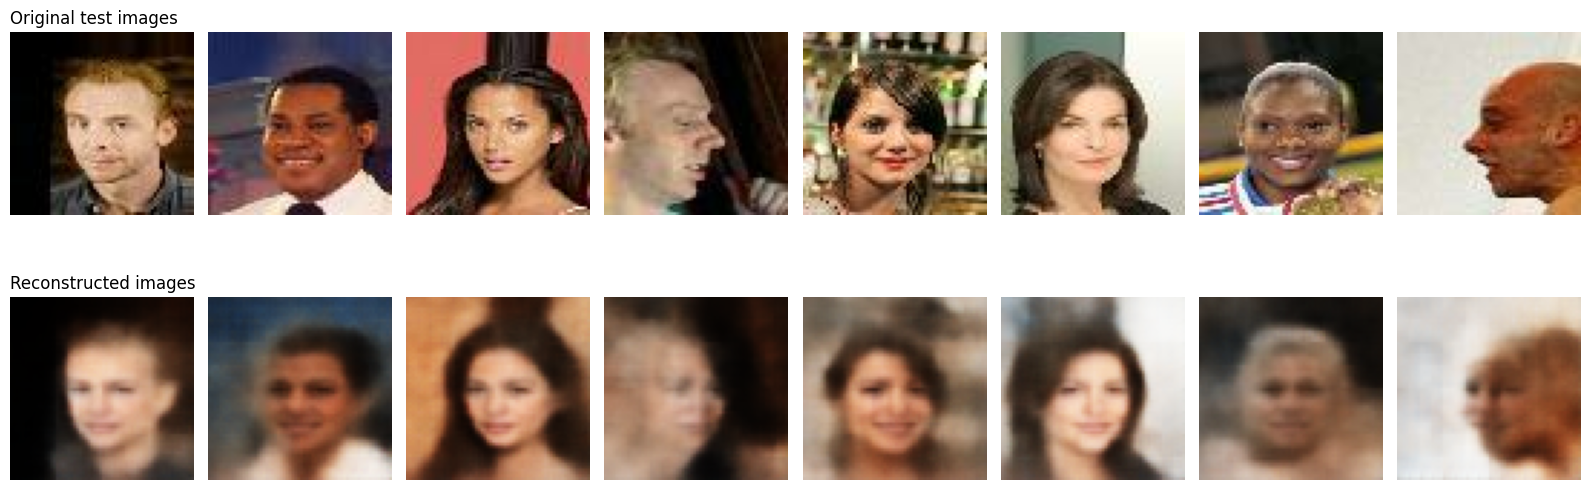

In [56]:
# Use your function to compute and visualise reconstructions

for test_batch in test_ds.shuffle(100).take(1):
    reconstructions = reconstruct(encoder, decoder, test_batch)

test_batch_size = 8
f, axs = plt.subplots(2, test_batch_size, figsize=(16, 6))
axs[0, 0].set_title("Original test images", loc='left')
axs[1, 0].set_title("Reconstructed images", loc='left')
for j in range(test_batch_size):
    axs[0, j].imshow(ops.convert_to_numpy(test_batch)[j])
    axs[1, j].imshow(ops.convert_to_numpy(reconstructions)[j])
    axs[0, j].axis('off')
    axs[1, j].axis('off')
plt.tight_layout()

#### Sample from the generative model

You should complete the following `generate_images` function to generate new images. This function takes the prior distribution and decoder network as arguments, as well as the number of samples to generate. This function should be completed according to the following:

* Sample a batch of `n_samples` images from the prior distribution, to obtain a latent vector Tensor of shape `(n_samples, 50)`
* Pass this batch of latent vectors through the decoder, to obtain an Independent Bernoulli distribution with batch shape equal to `[n_samples]` and event shape equal to `[64, 64, 3]`.
* Compute the means of the output distribution
* The function should then return the means Tensor

In [57]:
 #### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def generate_images(prior, decoder, n_samples):
    """
    This function should compute generate new samples of images from the generative model,
    according to the above instructions.
    The function takes the prior distribution, decoder and number of samples as inputs, which
    should be used to generate the images.
    The function should then return the batch of generated images.
    """
    sampled_latent_vectors = prior.sample(n_samples)
    sampled_images = ops.sigmoid(decoder(sampled_latent_vectors))
    return sampled_images

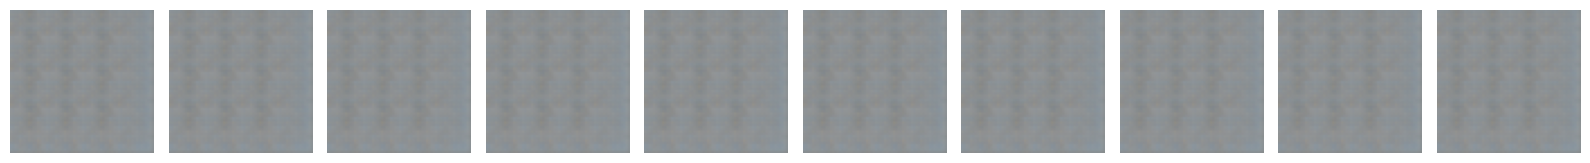

In [58]:
# Run your function to generate new images

n_samples = 10
sampled_images = ops.convert_to_numpy(generate_images(prior, decoder, n_samples))

f, axs = plt.subplots(1, n_samples, figsize=(16, 6))

for j in range(n_samples):
    axs[j].imshow(sampled_images[j])
    axs[j].axis('off')
plt.tight_layout()

#### Manipulate images in the latent space

In this final section, we will see how the latent space encodes high-level information about the images, even though it has not been trained with any information apart from the images themselves.

As mentioned earlier, each image in the CelebA dataset is labelled according to the attributes of the person pictured. The cell below will load these labels.

In [59]:
# Load the attribute labels

labels = pd.read_csv(Path('./data/list_attr_celeba_subset.csv'))
labels.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
1,000064.jpg,1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,-1,-1,-1,-1,-1,1
2,000076.jpg,-1,-1,1,1,-1,-1,-1,-1,1,...,1,1,-1,-1,-1,-1,-1,-1,-1,1
3,000128.jpg,-1,1,-1,1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,000129.jpg,1,-1,1,-1,-1,-1,-1,-1,1,...,1,1,-1,-1,-1,-1,-1,-1,1,1


As can be seen above, each image is labelled with a binary indicator (1 true, -1 false), according to whether it posseses the attribute. The list of attributes contained in the `labels` DataFrame is shown below.

In [60]:
# List the attributes contained in the DataFrame

labels.columns[1:]

Index(['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes',
       'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair',
       'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin',
       'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones',
       'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard',
       'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
       'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair',
       'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick',
       'Wearing_Necklace', 'Wearing_Necktie', 'Young'],
      dtype='object')

We would like to perform some computations in the latent space, depending on the attribute values in the `labels` DataFrame. To do this, we will construct a new Dataset object, containing the images and attribute information.

You should now complete the following `get_labelled_dataset` function to construct this new Dataset.

* The function takes the arguments `split` (which again will be one of the strings `'train'`, `'val'` or `'test'`), an `attribute` string, the `labels` DataFrame and `image_dir` string
  * The `attribute` will be one of the column headers listed above
* As before, the function should create a Dataset containing the filepaths saved in the corresponding `split` subfolder of the `image_dir` directory
* The function should include a nested function used to map the Dataset similar to before
  * It should again read the contents of the file, decode the jpeg and scale the pixel values to lie in the range $[0, 1]$
  * It should then look up the `attribute` value for the image from the `labels` DataFrame
  * It should return a tuple containing the image Tensor, and scalar `tf.int32` label Tensor
* The function should then apply the nested function using the `map` method
* The function should then return the Dataset

_Hint: convert the filenames and attribute columns of the_ `labels` _DataFrame into separate Tensor objects for use in the map function. The_ `tf.strings.split` _and_ `tf.where` _functions will be useful to extract the label for a given image._

In [61]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def get_labelled_dataset(split, attribute, labels=labels, image_dir=str(Path('data', 'images'))):
    """
    This function should create a tf.data.Dataset object for one of the train/valid/test
    splits, according to the above specification.
    It should then return the Dataset.
    """
    filenames = tf.constant(labels['image_id'])
    labels = tf.constant(labels[attribute], dtype=tf.int32)
    dataset = tf.data.Dataset.list_files(str(Path(image_dir, split, '*.jpg')), shuffle=False)
    
    def load_image(filepath):
        filename = tf.strings.split(filepath, '/')[-1]
        i = tf.where(filenames == filename)
        raw_img = tf.io.read_file(filepath) 
        img_tensor = tf.image.decode_jpeg(raw_img, channels=3)
        img_tensor = tf.image.convert_image_dtype(img_tensor, tf.float32)
        label = labels[tf.squeeze(i)]
        return img_tensor, label
    
    dataset = dataset.map(load_image)
    return dataset

In [62]:
# Create the labelled Dataset from the train split

labelled_train_ds = get_labelled_dataset('train', 'Eyeglasses', labels=labels)

We now would like to compute the 'attribute vector' for the chosen attribute. This will be the average latent vector corresponding to all images that have the attribute, minus the average latent vector corresponding to all images that do not have the attribute. The intuition is that this vector will correspond the high-level property of adding the attribute to an image.

You should now complete the following function to compute the attribute vector.

* The function takes `labelled_dataset` as an argument, as well as the `encoder` network
* The function should compute the encoding distribution mean (latent vector) for all images that have the attribute, and (separately) all the images that do not
* It should then compute the average of each of these two sets of latent vectors
* It should then compute `avg_latent_with_attribute - avg_latent_without_attribute`. This is the attribute vector
* The function should then return the attribute vector as a numpy array of shape `(latent_dim,)`

In [67]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def get_attribute_vector(labelled_dataset, encoder, latent_dim):
    """
    This function should compute and return the attribute vector according 
    to the above specification.
    """
    with_attribute_ds = labelled_dataset.filter(lambda i, l: tf.math.equal(l, 1)).batch(128)
    without_attribute_ds = labelled_dataset.filter(lambda i, l: tf.math.equal(l, -1)).batch(128)
    
    avg_latent_with_attribute = np.empty(shape=(0, latent_dim), dtype=np.float32)
    for images, _ in with_attribute_ds:
        latents, _  = encoder(images)
        avg_latent_with_attribute = np.concatenate((avg_latent_with_attribute, ops.convert_to_numpy(latents)), 
                                                   axis=0)
    avg_latent_with_attribute = np.mean(avg_latent_with_attribute, axis=0)    
    
    avg_latent_without_attribute = np.empty(shape=(0, latent_dim), dtype=np.float32)
    for images, _ in without_attribute_ds:
        latents, _ = encoder(images)
        avg_latent_without_attribute = np.concatenate((avg_latent_without_attribute, ops.convert_to_numpy(latents)), 
                                                      axis=0)
    avg_latent_without_attribute = np.mean(avg_latent_without_attribute, axis=0)    
    
    return avg_latent_with_attribute - avg_latent_without_attribute

In [68]:
# Get the attribute vector using your function

attribute_vector = get_attribute_vector(labelled_train_ds, encoder, latent_dim=50)

2024-08-27 07:49:01.270329: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-27 07:49:05.368468: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


We can view this attribute vector by decoding it:

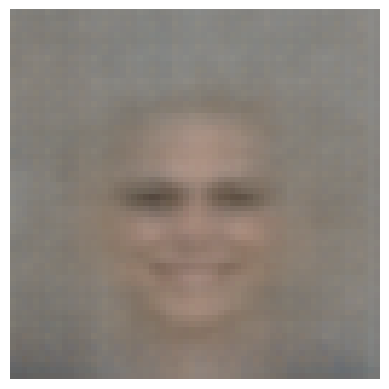

In [70]:
# Display the decoded attribute vector

decoded_a = ops.sigmoid(decoder(attribute_vector[np.newaxis, ...]))
plt.imshow(ops.convert_to_numpy(decoded_a).squeeze())
plt.axis('off');

We can now use the attribute vector to add the attribute to an image reconstruction, where that attribute wasn't present before. To do this, we can just add the attribute vector to the latent vector encoding of the image, and then decode the result. We can also adjust the strength of the attribute vector by scaling with a multiplicative parameter.

In [73]:
# Add the attribute vector to a sample of images that don't have the attribute

k = 2.5  # Weighting of attribute vector
num_examples = 8
labelled_test_ds = get_labelled_dataset('test', 'Eyeglasses', labels=labels).shuffle(100)
images_without_attribute = []
reconstructions = []
modified_images = []
for image, label in labelled_test_ds:
    if label == 1:  # Only proceses images without the attribute
        continue
    else:
        images_without_attribute.append(ops.convert_to_numpy(image))
        encoding, _ = encoder(image[tf.newaxis, ...])
        encoding = ops.convert_to_numpy(encoding)
        decoded_image = ops.sigmoid(decoder(encoding))
        reconstructions.append(np.squeeze(ops.convert_to_numpy(decoded_image)))
        modified_encoding = encoding + (k * attribute_vector)
        modified_reconstruction = ops.sigmoid(decoder(modified_encoding))
        modified_images.append(np.squeeze(ops.convert_to_numpy(modified_reconstruction)))
    if len(modified_images) >= num_examples:
        break

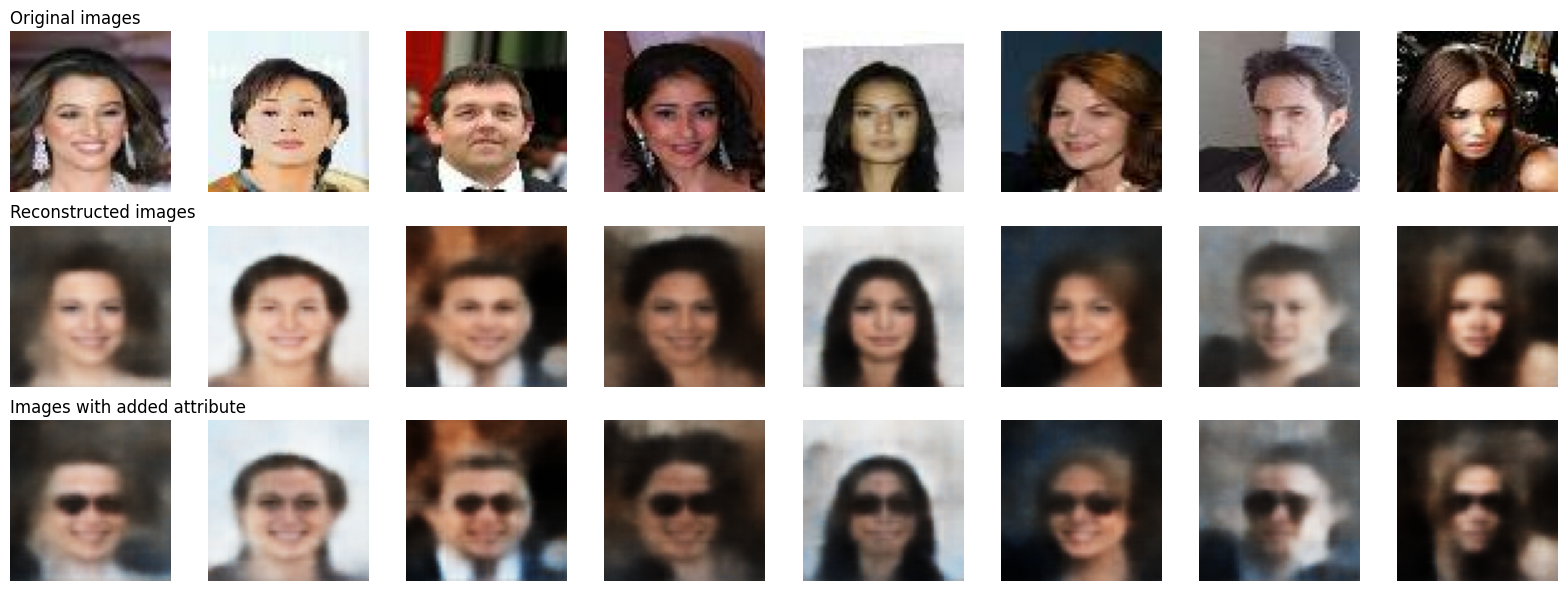

In [74]:
# Display the original images, their reconstructions, and modified reconstructions

num_examples = 8
f, axs = plt.subplots(3, num_examples, figsize=(16, 6))
axs[0, 0].set_title("Original images", loc='left')
axs[1, 0].set_title("Reconstructed images", loc='left')
axs[2, 0].set_title("Images with added attribute", loc='left')
for j in range(num_examples):
    axs[0, j].imshow(images_without_attribute[j])
    axs[1, j].imshow(reconstructions[j])
    axs[2, j].imshow(modified_images[j])
    for ax in axs[:, j]: ax.axis('off')
    
plt.tight_layout();

You could also try removing the attribute from images that possess the attribute, or experiment with a different attribute.

Congratulations on completing this week's assignment! In this assignment you have developed the variational autoencoder algorithm for the CelebA dataset, using tools from the TensorFlow Probability library, and used the trained networks to generate samples, compute reconstructions, and modify dataset images with high-level semantic information extracted from the latent space.